In [1]:
import os
import sys
from functools import partial
import warnings

import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from sklearn.externals import joblib
%matplotlib inline
import seaborn as sns

sys.path.append('../')
from src.utils import parallel_apply
from src.feature_extraction import add_features_in_group

warnings.filterwarnings('ignore')

#DIR = '/PATH/TO/YOUR/DATA'
DIR = '/mnt/ml-team/minerva/open-solutions/home-credit'
description = pd.read_csv(os.path.join(DIR,'data/HomeCredit_columns_description.csv'),encoding = 'latin1')
application = pd.read_csv(os.path.join(DIR, 'files/unzipped_data/application_train.csv'))
bureau = pd.read_csv(os.path.join(DIR, 'files/unzipped_data/bureau.csv'))

In [2]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


# Preprocessing
## Solution 3

In [3]:
(bureau['AMT_CREDIT_SUM'] == 0).sum()

66582

This shows that imputing with nan with 0 is probably a bad idea

# Feature Engineering
## Solution 3
### Hand crafted features

In [4]:
bureau[bureau['SK_ID_CURR']==215354]

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.00,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.00,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN
5,215354,5714467,Active,currency 1,-273,0,27460.0,NaN,0.0,0,180000.0,71017.38,108982.62,0.0,Credit card,-31,NaN
6,215354,5714468,Active,currency 1,-43,0,79.0,NaN,0.0,0,42103.8,42103.80,0.00,0.0,Consumer credit,-22,NaN
225157,215354,5714458,Closed,currency 1,-1872,0,-776.0,-1203.0,NaN,0,494550.0,0.00,0.00,0.0,Consumer credit,-696,NaN
225158,215354,5714459,Closed,currency 1,-1734,0,-638.0,-1336.0,NaN,0,1084032.0,0.00,NaN,0.0,Car loan,-1336,NaN
225159,215354,5714460,Closed,currency 1,-1333,0,-1089.0,-987.0,NaN,0,102150.0,NaN,NaN,0.0,Consumer credit,-984,NaN


### First build helper columns

In [5]:
bureau['bureau_credit_active_binary'] = (bureau['CREDIT_ACTIVE'] != 'Closed').astype(int)
bureau['bureau_credit_enddate_binary'] = (bureau['DAYS_CREDIT_ENDDATE'] > 0).astype(int)
groupby_SK_ID_CURR = bureau.groupby(by=['SK_ID_CURR'])

In [6]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,bureau_credit_active_binary,bureau_credit_enddate_binary
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN,0,0
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN,1,1
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN,1,1
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN,1,0
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN,1,1


In [7]:
description[description['Row'] == 'DAYS_CREDIT'].Description.tolist()

['How many days before current application did client apply for Credit Bureau credit']

In [8]:
features = pd.DataFrame({'SK_ID_CURR':bureau['SK_ID_CURR'].unique()})
features.head()

,SK_ID_CURR
0,215354
1,162297
2,402440
3,238881
4,222183


In [9]:
group_object = groupby_SK_ID_CURR['DAYS_CREDIT'].agg('count').reset_index()
group_object.rename(index=str, columns={'DAYS_CREDIT': 'bureau_number_of_past_loans'},inplace=True)

features = features.merge(group_object, on=['SK_ID_CURR'], how='left')
features.head()

,SK_ID_CURR,bureau_number_of_past_loans
0,215354,11
1,162297,6
2,402440,1
3,238881,8
4,222183,8


In [10]:
group_object = groupby_SK_ID_CURR['CREDIT_TYPE'].agg('nunique').reset_index()
group_object.rename(index=str, columns={'CREDIT_TYPE': 'bureau_number_of_loan_types'},inplace=True)

features = features.merge(group_object, on=['SK_ID_CURR'], how='left')
features.head()

,SK_ID_CURR,bureau_number_of_past_loans,bureau_number_of_loan_types
0,215354,11,3
1,162297,6,3
2,402440,1,1
3,238881,8,2
4,222183,8,3


In [11]:
features['bureau_average_of_past_loans_per_type'] = \
    features['bureau_number_of_past_loans'] / features['bureau_number_of_loan_types']
    
features.head()

,SK_ID_CURR,bureau_number_of_past_loans,bureau_number_of_loan_types,bureau_average_of_past_loans_per_type
0,215354,11,3,3.666667
1,162297,6,3,2.000000
2,402440,1,1,1.000000
3,238881,8,2,4.000000
4,222183,8,3,2.666667


In [12]:
group_object = groupby_SK_ID_CURR['bureau_credit_active_binary'].agg('mean').reset_index()

features = features.merge(group_object, on=['SK_ID_CURR'], how='left')
features.head()

,SK_ID_CURR,bureau_number_of_past_loans,bureau_number_of_loan_types,bureau_average_of_past_loans_per_type,bureau_credit_active_binary
0,215354,11,3,3.666667,0.545455
1,162297,6,3,2.000000,0.500000
2,402440,1,1,1.000000,1.000000
3,238881,8,2,4.000000,0.375000
4,222183,8,3,2.666667,0.625000


In [13]:
group_object = groupby_SK_ID_CURR['AMT_CREDIT_SUM_DEBT'].agg('sum').reset_index()
group_object.rename(index=str, columns={'AMT_CREDIT_SUM_DEBT': 'bureau_total_customer_debt'},inplace=True)

features = features.merge(group_object, on=['SK_ID_CURR'], how='left')
features.head()

,SK_ID_CURR,bureau_number_of_past_loans,bureau_number_of_loan_types,bureau_average_of_past_loans_per_type,bureau_credit_active_binary,bureau_total_customer_debt
0,215354,11,3,3.666667,0.545455,284463.18
1,162297,6,3,2.000000,0.500000,0.00
2,402440,1,1,1.000000,1.000000,76905.00
3,238881,8,2,4.000000,0.375000,552730.50
4,222183,8,3,2.666667,0.625000,1185081.84


In [14]:
group_object = groupby_SK_ID_CURR['AMT_CREDIT_SUM'].agg('sum').reset_index()
group_object.rename(index=str, columns={'AMT_CREDIT_SUM': 'bureau_total_customer_credit'},inplace=True)

features = features.merge(group_object, on=['SK_ID_CURR'], how='left')
features.head()

,SK_ID_CURR,bureau_number_of_past_loans,bureau_number_of_loan_types,bureau_average_of_past_loans_per_type,bureau_credit_active_binary,bureau_total_customer_debt,bureau_total_customer_credit
0,215354,11,3,3.666667,0.545455,284463.18,5973945.30
1,162297,6,3,2.000000,0.500000,0.00,8230386.15
2,402440,1,1,1.000000,1.000000,76905.00,89910.00
3,238881,8,2,4.000000,0.375000,552730.50,1285239.06
4,222183,8,3,2.666667,0.625000,1185081.84,7158960.00


In [15]:
features['bureau_debt_credit_ratio'] = \
    features['bureau_total_customer_debt'] / features['bureau_total_customer_credit']
    
features.head()

,SK_ID_CURR,bureau_number_of_past_loans,bureau_number_of_loan_types,bureau_average_of_past_loans_per_type,bureau_credit_active_binary,bureau_total_customer_debt,bureau_total_customer_credit,bureau_debt_credit_ratio
0,215354,11,3,3.666667,0.545455,284463.18,5973945.30,0.047617
1,162297,6,3,2.000000,0.500000,0.00,8230386.15,0.000000
2,402440,1,1,1.000000,1.000000,76905.00,89910.00,0.855355
3,238881,8,2,4.000000,0.375000,552730.50,1285239.06,0.430060
4,222183,8,3,2.666667,0.625000,1185081.84,7158960.00,0.165538


In [16]:
group_object = groupby_SK_ID_CURR['AMT_CREDIT_SUM_OVERDUE'].agg('sum').reset_index()
group_object.rename(index=str, columns={'AMT_CREDIT_SUM_OVERDUE': 'bureau_total_customer_overdue'},inplace=True)

features = features.merge(group_object, on=['SK_ID_CURR'], how='left')
features.head()

,SK_ID_CURR,bureau_number_of_past_loans,bureau_number_of_loan_types,bureau_average_of_past_loans_per_type,bureau_credit_active_binary,bureau_total_customer_debt,bureau_total_customer_credit,bureau_debt_credit_ratio,bureau_total_customer_overdue
0,215354,11,3,3.666667,0.545455,284463.18,5973945.30,0.047617,0.0
1,162297,6,3,2.000000,0.500000,0.00,8230386.15,0.000000,0.0
2,402440,1,1,1.000000,1.000000,76905.00,89910.00,0.855355,0.0
3,238881,8,2,4.000000,0.375000,552730.50,1285239.06,0.430060,0.0
4,222183,8,3,2.666667,0.625000,1185081.84,7158960.00,0.165538,0.0


In [17]:
features['bureau_overdue_debt_ratio'] = \
    features['bureau_total_customer_overdue'] / features['bureau_total_customer_debt']
    
features.head()

,SK_ID_CURR,bureau_number_of_past_loans,bureau_number_of_loan_types,bureau_average_of_past_loans_per_type,bureau_credit_active_binary,bureau_total_customer_debt,bureau_total_customer_credit,bureau_debt_credit_ratio,bureau_total_customer_overdue,bureau_overdue_debt_ratio
0,215354,11,3,3.666667,0.545455,284463.18,5973945.30,0.047617,0.0,0.0
1,162297,6,3,2.000000,0.500000,0.00,8230386.15,0.000000,0.0,NaN
2,402440,1,1,1.000000,1.000000,76905.00,89910.00,0.855355,0.0,0.0
3,238881,8,2,4.000000,0.375000,552730.50,1285239.06,0.430060,0.0,0.0
4,222183,8,3,2.666667,0.625000,1185081.84,7158960.00,0.165538,0.0,0.0


In [18]:
group_object = groupby_SK_ID_CURR['CNT_CREDIT_PROLONG'].agg('sum').reset_index()
group_object.rename(index=str, columns={'CNT_CREDIT_PROLONG': 'bureau_total_prolonged_count'},inplace=True)

features = features.merge(group_object, on=['SK_ID_CURR'], how='left')
features.head()

,SK_ID_CURR,bureau_number_of_past_loans,bureau_number_of_loan_types,bureau_average_of_past_loans_per_type,bureau_credit_active_binary,bureau_total_customer_debt,bureau_total_customer_credit,bureau_debt_credit_ratio,bureau_total_customer_overdue,bureau_overdue_debt_ratio,bureau_total_prolonged_count
0,215354,11,3,3.666667,0.545455,284463.18,5973945.30,0.047617,0.0,0.0,0
1,162297,6,3,2.000000,0.500000,0.00,8230386.15,0.000000,0.0,NaN,0
2,402440,1,1,1.000000,1.000000,76905.00,89910.00,0.855355,0.0,0.0,0
3,238881,8,2,4.000000,0.375000,552730.50,1285239.06,0.430060,0.0,0.0,0
4,222183,8,3,2.666667,0.625000,1185081.84,7158960.00,0.165538,0.0,0.0,0


In [19]:
group_object = groupby_SK_ID_CURR['bureau_credit_enddate_binary'].agg('mean').reset_index()
group_object.rename(index=str, columns={'bureau_credit_enddate_binary': 'bureau_credit_enddate_percentage'},inplace=True)

features = features.merge(group_object, on=['SK_ID_CURR'], how='left')
features.head()

,SK_ID_CURR,bureau_number_of_past_loans,bureau_number_of_loan_types,bureau_average_of_past_loans_per_type,bureau_credit_active_binary,bureau_total_customer_debt,bureau_total_customer_credit,bureau_debt_credit_ratio,bureau_total_customer_overdue,bureau_overdue_debt_ratio,bureau_total_prolonged_count,bureau_credit_enddate_percentage
0,215354,11,3,3.666667,0.545455,284463.18,5973945.30,0.047617,0.0,0.0,0,0.454545
1,162297,6,3,2.000000,0.500000,0.00,8230386.15,0.000000,0.0,NaN,0,0.166667
2,402440,1,1,1.000000,1.000000,76905.00,89910.00,0.855355,0.0,0.0,0,1.000000
3,238881,8,2,4.000000,0.375000,552730.50,1285239.06,0.430060,0.0,0.0,0,0.125000
4,222183,8,3,2.666667,0.625000,1185081.84,7158960.00,0.165538,0.0,0.0,0,0.625000


In [20]:
X = application.merge(features,
                                left_on=['SK_ID_CURR'],
                                right_on=['SK_ID_CURR'],
                                how='left',
                                validate='one_to_one')

In [21]:
engineered_numerical_columns = list(features.columns)
engineered_numerical_columns.remove('SK_ID_CURR')
X = X[engineered_numerical_columns + ['TARGET']]
X_corr = abs(X.corr())

In [22]:
X_corr.sort_values('TARGET', ascending=False)['TARGET']

TARGET                                   1.000000
bureau_credit_active_binary              0.079369
bureau_debt_credit_ratio                 0.060235
bureau_credit_enddate_percentage         0.055305
bureau_total_customer_credit             0.014057
bureau_total_customer_overdue            0.013335
bureau_total_customer_debt               0.007144
bureau_average_of_past_loans_per_type    0.006118
bureau_number_of_loan_types              0.004624
bureau_total_prolonged_count             0.004058
bureau_number_of_past_loans              0.004056
bureau_overdue_debt_ratio                0.000939
Name: TARGET, dtype: float64

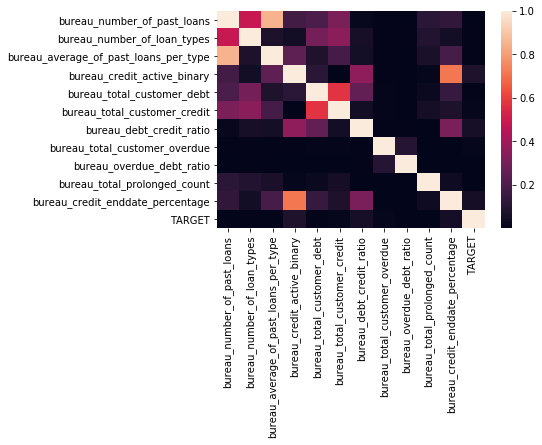

In [23]:
sns.heatmap(X_corr, 
            xticklabels=X_corr.columns,
            yticklabels=X_corr.columns)

## Aggregations

In [24]:
BUREAU_AGGREGATION_RECIPIES = [('CREDIT_TYPE', 'count'),
                               ('CREDIT_ACTIVE', 'size')
                               ]
for agg in ['mean', 'min', 'max', 'sum', 'var']:
    for select in ['AMT_ANNUITY',
                   'AMT_CREDIT_SUM',
                   'AMT_CREDIT_SUM_DEBT',
                   'AMT_CREDIT_SUM_LIMIT',
                   'AMT_CREDIT_SUM_OVERDUE',
                   'AMT_CREDIT_MAX_OVERDUE',
                   'CNT_CREDIT_PROLONG',
                   'CREDIT_DAY_OVERDUE',
                   'DAYS_CREDIT',
                   'DAYS_CREDIT_ENDDATE',
                   'DAYS_CREDIT_UPDATE'
                   ]:
        BUREAU_AGGREGATION_RECIPIES.append((select, agg))
BUREAU_AGGREGATION_RECIPIES = [(['SK_ID_CURR'], BUREAU_AGGREGATION_RECIPIES)]

In [25]:
groupby_aggregate_names = []
for groupby_cols, specs in tqdm(BUREAU_AGGREGATION_RECIPIES):
    group_object = bureau.groupby(groupby_cols)
    for select, agg in tqdm(specs):
        groupby_aggregate_name = '{}_{}_{}'.format('_'.join(groupby_cols), agg, select)
        application = application.merge(group_object[select]
                              .agg(agg)
                              .reset_index()
                              .rename(index=str,
                                      columns={select: groupby_aggregate_name})
                              [groupby_cols + [groupby_aggregate_name]],
                              on=groupby_cols,
                              how='left')
        groupby_aggregate_names.append(groupby_aggregate_name)

In [26]:
application.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,SK_ID_CURR_var_AMT_CREDIT_SUM,SK_ID_CURR_var_AMT_CREDIT_SUM_DEBT,SK_ID_CURR_var_AMT_CREDIT_SUM_LIMIT,SK_ID_CURR_var_AMT_CREDIT_SUM_OVERDUE,SK_ID_CURR_var_AMT_CREDIT_MAX_OVERDUE,SK_ID_CURR_var_CNT_CREDIT_PROLONG,SK_ID_CURR_var_CREDIT_DAY_OVERDUE,SK_ID_CURR_var_DAYS_CREDIT,SK_ID_CURR_var_DAYS_CREDIT_ENDDATE,SK_ID_CURR_var_DAYS_CREDIT_UPDATE
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,2.133807e+10,1.208166e+10,2.558171e+08,0.0,5.584936e+06,0.0,0.0,186150.000000,5.890424e+05,268865.553571
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,1.385846e+11,0.000000e+00,1.640250e+11,0.0,0.000000e+00,0.0,0.0,827783.583333,2.228364e+06,824562.000000
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,7.144200e+02,0.000000e+00,0.000000e+00,0.0,NaN,0.0,0.0,421362.000000,2.268450e+04,45000.000000
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
application_agg = application[groupby_aggregate_names + ['TARGET']]
application_agg_corr = abs(application_agg.corr())

In [28]:
application_agg_corr.sort_values('TARGET', ascending=False)['TARGET']

TARGET                                    1.000000
SK_ID_CURR_mean_DAYS_CREDIT               0.089729
SK_ID_CURR_min_DAYS_CREDIT                0.075248
SK_ID_CURR_mean_DAYS_CREDIT_UPDATE        0.068927
SK_ID_CURR_sum_DAYS_CREDIT_ENDDATE        0.053735
SK_ID_CURR_max_DAYS_CREDIT                0.049782
SK_ID_CURR_mean_DAYS_CREDIT_ENDDATE       0.046983
SK_ID_CURR_min_DAYS_CREDIT_UPDATE         0.042864
SK_ID_CURR_sum_DAYS_CREDIT                0.042000
SK_ID_CURR_sum_DAYS_CREDIT_UPDATE         0.041404
SK_ID_CURR_var_DAYS_CREDIT                0.038440
SK_ID_CURR_var_DAYS_CREDIT_ENDDATE        0.037370
SK_ID_CURR_max_DAYS_CREDIT_ENDDATE        0.036590
SK_ID_CURR_min_DAYS_CREDIT_ENDDATE        0.034281
SK_ID_CURR_max_DAYS_CREDIT_UPDATE         0.028234
SK_ID_CURR_mean_AMT_CREDIT_SUM            0.019957
SK_ID_CURR_max_AMT_CREDIT_SUM             0.019737
SK_ID_CURR_sum_AMT_CREDIT_SUM             0.014057
SK_ID_CURR_sum_AMT_CREDIT_SUM_OVERDUE     0.013335
SK_ID_CURR_mean_AMT_CREDIT_SUM_

# Solution 6
## Hand Crafted Features

In [29]:
bureau['bureau_credit_type_consumer'] = (bureau['CREDIT_TYPE'] == 'Consumer credit').astype(int)
bureau['bureau_credit_type_car'] = (bureau['CREDIT_TYPE'] == 'Car loan').astype(int)
bureau['bureau_credit_type_mortgage'] = (bureau['CREDIT_TYPE'] == 'Mortgage').astype(int)
bureau['bureau_credit_type_credit_card'] = (bureau['CREDIT_TYPE'] == 'Credit card').astype(int)
bureau['bureau_credit_type_other'] = (~(bureau['CREDIT_TYPE'].isin(['Consumer credit',
                                                        'Car loan', 'Mortgage', 'Credit card']))).astype(int)
bureau['bureau_unusual_currency'] = (~(bureau['CREDIT_CURRENCY'] == 'currency 1')).astype(int)

In [30]:
groupby_SK_ID_CURR = bureau.groupby(by=['SK_ID_CURR'])
group_object = groupby_SK_ID_CURR[['bureau_credit_type_consumer',
                                   'bureau_credit_type_car',
                                   'bureau_credit_type_mortgage',
                                   'bureau_credit_type_credit_card',
                                   'bureau_credit_type_other',
                                   'bureau_unusual_currency']].agg(['sum', 'mean']).reset_index()

group_object.columns = ['{}_{}'.format(a,b) for a,b in group_object.columns.tolist()]
group_object.rename(index=str, columns={'SK_ID_CURR_': 'SK_ID_CURR'},inplace=True)
features = features.merge(group_object, on=['SK_ID_CURR'], how='left')
features.head()

,SK_ID_CURR,bureau_number_of_past_loans,bureau_number_of_loan_types,bureau_average_of_past_loans_per_type,bureau_credit_active_binary,bureau_total_customer_debt,bureau_total_customer_credit,bureau_debt_credit_ratio,bureau_total_customer_overdue,bureau_overdue_debt_ratio,...,bureau_credit_type_car_sum,bureau_credit_type_car_mean,bureau_credit_type_mortgage_sum,bureau_credit_type_mortgage_mean,bureau_credit_type_credit_card_sum,bureau_credit_type_credit_card_mean,bureau_credit_type_other_sum,bureau_credit_type_other_mean,bureau_unusual_currency_sum,bureau_unusual_currency_mean
0,215354,11,3,3.666667,0.545455,284463.18,5973945.30,0.047617,0.0,0.0,...,1,0.090909,0,0.000000,3,0.272727,0,0.0,0,0.0
1,162297,6,3,2.000000,0.500000,0.00,8230386.15,0.000000,0.0,NaN,...,0,0.000000,1,0.166667,2,0.333333,0,0.0,0,0.0
2,402440,1,1,1.000000,1.000000,76905.00,89910.00,0.855355,0.0,0.0,...,0,0.000000,0,0.000000,0,0.000000,0,0.0,0,0.0
3,238881,8,2,4.000000,0.375000,552730.50,1285239.06,0.430060,0.0,0.0,...,0,0.000000,0,0.000000,3,0.375000,0,0.0,0,0.0
4,222183,8,3,2.666667,0.625000,1185081.84,7158960.00,0.165538,0.0,0.0,...,1,0.125000,0,0.000000,3,0.375000,0,0.0,0,0.0


In [31]:
COLUMN_NAME = 'DAYS_CREDIT_UPDATE'
d = description[description['Row']==COLUMN_NAME]
display(d.Description.tolist())
display(d.Special.tolist())

['How many days before loan application did last information about the Credit Bureau credit come']

['time only relative to the application']

In [32]:
bureau.sort_values(['SK_ID_CURR','DAYS_CREDIT'],ascending=False, inplace=True)
bureau['days_credit_diff'] = bureau['DAYS_CREDIT'].diff().replace(np.nan, 0)    

groupby_SK_ID_CURR = bureau.groupby(by=['SK_ID_CURR'])

In [33]:
group_object = groupby_SK_ID_CURR['bureau_credit_active_binary'].agg('sum').reset_index()
group_object.rename(index=str, columns={'bureau_credit_active_count': 'bureau_credit_active_binary'},inplace=True)

features = features.merge(group_object, on=['SK_ID_CURR'], how='left')

In [34]:
group_object = groupby_SK_ID_CURR['SK_ID_BUREAU'].agg('nunique').reset_index()
group_object.rename(index=str, columns={'SK_ID_BUREAU': 'bureau_query_count'},inplace=True)

features = features.merge(group_object, on=['SK_ID_CURR'], how='left')

In [35]:
def last_k_bureau_features(gr, periods):
    gr_ = gr.copy()

    features = {}
    for period in periods:
        if period > 10e10:
            period_name = 'all_records_'
            gr_period = gr_.copy()
        else:
            period_name = 'last_{}_'.format(period)
            gr_period = gr_[gr_['DAYS_CREDIT'] >= (-1) * period]

        features = add_features_in_group(features, gr_period, 'days_credit_diff',
                                             ['sum', 'min', 'max', 'median', 'std'],
                                        period_name)
        features = add_features_in_group(features, gr_period, 'CNT_CREDIT_PROLONG',
                                             ['sum', 'std'],
                                        period_name)
        features = add_features_in_group(features, gr_period, 'bureau_credit_active_binary',
                                             ['sum', 'mean'],
                                        period_name)
        features = add_features_in_group(features, gr_period, 'bureau_credit_type_consumer',
                                             ['sum', 'mean'],
                                        period_name)
        features = add_features_in_group(features, gr_period, 'bureau_credit_type_car',
                                             ['sum', 'mean'],
                                        period_name)
        features = add_features_in_group(features, gr_period, 'bureau_credit_type_credit_card',
                                             ['sum'],
                                        period_name)
        features = add_features_in_group(features, gr_period, 'bureau_credit_type_mortgage',
                                             ['sum'],
                                        period_name)
        features = add_features_in_group(features, gr_period, 'bureau_credit_type_other',
                                             ['sum', 'mean'],
                                        period_name)
    return features


def trend_in_last_k_bureau_features(gr, periods):
    gr_ = gr.copy()
    gr_['days_credit_diff'].iloc[0] = 0

    features = {}

    for period in periods:
        gr_period = gr_[gr_['DAYS_CREDIT'] >= (-1) * period]
        features = _add_trend_feature(features,gr_period,
                                      'days_credit_diff','{}_period_trend_'.format(period)
                                     )
    return features


def _add_trend_feature(features, gr ,feature_name, prefix):
    y = gr[feature_name].values
    try:
        x = np.arange(0,len(y)).reshape(-1,1)
        lr = LinearRegression()
        lr.fit(x,y)
        trend = lr.coef_[0]
    except:
        trend=np.nan
    features['{}{}'.format(prefix,feature_name)] = trend
    return features

In [36]:
func = partial(last_k_bureau_features, periods=[60, 180, 360, 720, 1e25])

g = parallel_apply(groupby_SK_ID_CURR, func, index_name='SK_ID_CURR',
                   num_workers=10, chunk_size=10000).reset_index()
features = features.merge(g, on='SK_ID_CURR', how='left')

display(features.head())

100%|██████████| 31/31.0 [10:27<00:00, 20.23s/it]


,SK_ID_CURR,bureau_number_of_past_loans,bureau_number_of_loan_types,bureau_average_of_past_loans_per_type,bureau_credit_active_binary_x,bureau_total_customer_debt,bureau_total_customer_credit,bureau_debt_credit_ratio,bureau_total_customer_overdue,bureau_overdue_debt_ratio,...,last_720_bureau_credit_type_consumer_sum,last_720_bureau_credit_type_credit_card_sum,last_720_bureau_credit_type_mortgage_sum,last_720_bureau_credit_type_other_mean,last_720_bureau_credit_type_other_sum,last_720_days_credit_diff_max,last_720_days_credit_diff_median,last_720_days_credit_diff_min,last_720_days_credit_diff_std,last_720_days_credit_diff_sum
0,215354,11,3,3.666667,0.545455,284463.18,5973945.30,0.047617,0.0,0.0,...,4,3,0,0.0,0,2192.0,-65.0,-224.0,869.276683,1606.0
1,162297,6,3,2.000000,0.500000,0.00,8230386.15,0.000000,0.0,NaN,...,0,0,1,0.0,0,2545.0,2545.0,2545.0,NaN,2545.0
2,402440,1,1,1.000000,1.000000,76905.00,89910.00,0.855355,0.0,0.0,...,1,0,0,0.0,0,2430.0,2430.0,2430.0,NaN,2430.0
3,238881,8,2,4.000000,0.375000,552730.50,1285239.06,0.430060,0.0,0.0,...,3,3,0,0.0,0,1348.0,-57.5,-223.0,599.569735,814.0
4,222183,8,3,2.666667,0.625000,1185081.84,7158960.00,0.165538,0.0,0.0,...,1,0,0,0.0,0,2212.0,1066.0,-80.0,1620.688742,2132.0


In [37]:
features.shape

(305811, 111)

In [38]:
X = application.merge(features,
                      left_on=['SK_ID_CURR'],
                      right_on=['SK_ID_CURR'],
                                how='left',
                                validate='one_to_one')

In [ ]:
feature_names = list(features.columns)
feature_names.remove('SK_ID_CURR')
X = X[feature_names + ['TARGET']]
X_abs = abs(X.corr())

In [ ]:
X_abs.sort_values('TARGET', ascending=False)['TARGET']

In [ ]:
regex = 'credit_active'
X_corr_truncated = X_abs.sort_values('TARGET', ascending=False).filter(regex=regex, axis=0)
X_corr_truncated['TARGET']

In [ ]:
colnames = X_corr_truncated.index.tolist() + ['TARGET']
X_corr_truncated[colnames]

In [ ]:
sns.heatmap(X_corr_truncated[colnames], 
            xticklabels=colnames,
            yticklabels=colnames)